In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.32)], p=0.4),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

data_dir = '/content/drive/My Drive/Final Project/chest_xray/chest_xray'
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

for x in ['train', 'val', 'test']:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets['train'].classes
print(image_datasets['train'].classes)

Loaded 5223 images under train
Loaded 16 images under val
Loaded 624 images under test
Classes: 
['NORMAL', 'PNEUMONIA']


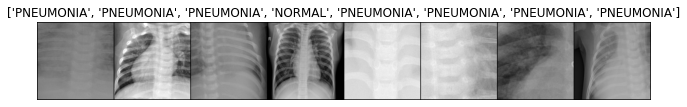

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(11, 11))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
show_databatch(inputs, classes)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    last_end = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            epoch_time = time.time() - last_end
            last_end = time.time()
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            print('Epoch Time {epoch_time:.3f}'.format(epoch_time=epoch_time))
            if phase == 'train':
                scheduler.step(epoch_loss)
            else:
                print('-' * 10)
    return model

In [ ]:
# Load the pretrained model from pytorch
model = models.resnet50(pretrained=True).to(device)

# print(model)
# Freeze training for all layers
for param in model.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
# Dropout(p=0.5) is also a good new layer
model.fc = nn.Sequential(
               nn.Linear(2048, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
criterion = nn.CrossEntropyLoss()
# Optimzer
optimizer = optim.Adadelta(model.fc.parameters(), lr=0.001)
# LR scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    patience=4,
                                                    cooldown=0,
                                                    verbose=True)

In [ ]:
model = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=8)

Epoch 1/8
----------
train loss: 0.5883, acc: 0.7383
Epoch Time 1320.311
val loss: 0.8701, acc: 0.5000
Epoch Time 7.371
----------
Epoch 2/8
----------
train loss: 0.5561, acc: 0.7433
Epoch Time 1313.447
val loss: 0.8338, acc: 0.5000
Epoch Time 3.409
----------
Epoch 3/8
----------
train loss: 0.5382, acc: 0.7434
Epoch Time 1318.797
val loss: 0.7782, acc: 0.5000
Epoch Time 3.462
----------
Epoch 4/8
----------
train loss: 0.5176, acc: 0.7440
Epoch Time 1321.455
val loss: 0.7615, acc: 0.5000
Epoch Time 3.561
----------
Epoch 5/8
----------
train loss: 0.5025, acc: 0.7463
Epoch Time 1322.702
val loss: 0.7545, acc: 0.5000
Epoch Time 3.484
----------
Epoch 6/8
----------
train loss: 0.4899, acc: 0.7498
Epoch Time 1320.927
val loss: 0.7217, acc: 0.5625
Epoch Time 3.573
----------
Epoch 7/8
----------
train loss: 0.4717, acc: 0.7572
Epoch Time 1333.086
val loss: 0.7236, acc: 0.5625
Epoch Time 3.663
----------
Epoch 8/8
----------
train loss: 0.4604, acc: 0.7699
Epoch Time 1369.691
val loss: 

In [ ]:
def test_model(model, criterion):
    last_end = time.time()
    print('-' * 10)
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(image_datasets['test'])
    epoch_acc = running_corrects.double() / len(image_datasets['test'])
    epoch_time = time.time() - last_end
    last_end = time.time()
    print('Test loss: {:.4f}, acc: {:.4f}'.format(epoch_loss,
                                                  epoch_acc))
    print('Test Time {epoch_time:.3f}'.format(epoch_time=epoch_time))
    print('-' * 10)

In [ ]:
test_model(model, criterion)

----------
Test loss: 0.5437, acc: 0.6635
Test Time 136.600
----------
